In [2]:
from scipy.optimize import least_squares, minimize, LinearConstraint, NonlinearConstraint, BFGS, SR1
import scipy.optimize as scopt
import numpy as np
import matplotlib.pyplot as plt
from toy_datasets import ToyDatasets
from scipy.stats import norm
import jax.numpy as jnp
import jax.random as jrd
from jax import jit, value_and_grad, jacrev
import jax
from functools import partial
import pandas as pd
import yfinance as yf

In [3]:
class Stage6Algorithm():
  def __init__(self, num_features, ar_order):
    self.num_features, self.ar_order = num_features, ar_order
    self.X, self.G, self.S, self.K = None, None, None, None
    self.dims = None

  def objective(self, params):
    (X_shape, X_len), (G_shape, G_len), (S_shape, S_len), (K_shape, K_len) = self.dims
    X, G, S = params[:X_len], params[X_len:X_len+G_len], params[X_len+G_len:X_len+G_len+S_len]
    X, G, S = X.reshape(X_shape), G.reshape(G_shape), S.reshape(S_shape)

    lg, ls, lx = 1, 1, 1
    objective_value = lg * np.linalg.norm(G) ** 2 + ls * np.linalg.norm(S, 1)

    return objective_value

  def hankel_constraint(self, params):
    (X_shape, X_len), (G_shape, G_len), (S_shape, S_len), (K_shape, K_len) = self.dims
    X, K_t = params[:X_len], params[X_len+G_len+S_len:]
    X, K_t = X.reshape(X_shape), K_t.reshape(K_shape)
    K = self.K
    K[-self.num_features:] = K_t

    X1, X2 = X[:, :-1], X[:, 1:]
    X1, X2 = X1[:, self.idx_ravel].reshape(self.num_features * self.ar_order, -1), X2[:, self.idx_ravel].reshape(self.num_features * self.ar_order, -1)
    return (X2 - K @ X1).flatten()

  def D_constraint(self, params):
    (X_shape, X_len), (G_shape, G_len), (S_shape, S_len), (K_shape, K_len) = self.dims
    X, G, S = params[:X_len], params[X_len:X_len+G_len], params[X_len+G_len:X_len+G_len+S_len]
    X, G, S = X.reshape(X_shape), G.reshape(G_shape), S.reshape(S_shape)
    return (self.D - X - G - S).flatten()
    
  def fit(self, D, bounds=None, retrain=False):
    if retrain:
      print("Using learned parameters")
      len_diff = D.shape[1] - self.X.shape[1]
      if len_diff == 0:
        X_initial_guess = self.X
      else:
        X_initial_guess = np.hstack((self.X, self.forecast(self.X, len_diff)))
      G_initial_guess, S_initial_guess, K_initial_guess = \
        np.hstack((self.G, np.zeros((D.shape[0], len_diff)))), np.hstack((self.S, np.zeros((D.shape[0], len_diff)))), self.K
    else:
      print("Learning from scratch")
      X_initial_guess, G_initial_guess, S_initial_guess, K_initial_guess = \
        D, np.random.normal(0, 0.01, D.shape), np.random.standard_t(3, D.shape) / 100, np.zeros((self.num_features, self.num_features*self.ar_order))

    min_val, max_val = D.min(axis=1).reshape(-1, 1), D.max(axis=1).reshape(-1, 1)
    self.min_val, self.max_val = min_val, max_val

    D = (D - min_val) / (max_val - min_val)
    X_initial_guess = (X_initial_guess - min_val) / (max_val - min_val)
    G_initial_guess = G_initial_guess / (max_val - min_val)
    S_initial_guess = S_initial_guess / (max_val - min_val)

    params = np.concatenate([X_initial_guess.flatten(), G_initial_guess.flatten(), S_initial_guess.flatten(), K_initial_guess.flatten()])
    dims = (
      (X_initial_guess.shape, len(X_initial_guess.flatten())),
      (G_initial_guess.shape, len(G_initial_guess.flatten())),
      (S_initial_guess.shape, len(S_initial_guess.flatten())),
      (K_initial_guess.shape, len(K_initial_guess.flatten()))
    )
    self.dims = dims

    self.D = D
    self.idx_ravel = (np.arange(self.ar_order)[:, None] + np.arange(D.shape[1] - self.ar_order)).ravel()

    K = np.zeros((self.num_features * self.ar_order, self.num_features * self.ar_order))
    rows, cols = np.diag_indices(self.num_features * self.ar_order - self.num_features)
    K[rows, cols + self.num_features] = 1
    self.K = K

    hankel_constraint = NonlinearConstraint(self.hankel_constraint, 0, 0)
    D_constraint = NonlinearConstraint(self.D_constraint, 0, 0)

    # constraints = (
    #   {'type': 'eq', 'fun': self.hankel_constraint, 'args': (K, dims[0][0], dims[0][1], dims[1][1], dims[2][1], dims[3][0], idx_ravel)},
    #   {'type': 'eq', 'fun': self.D_constraint, 'args': (D, dims[0][0], dims[0][1], dims[1][0], dims[1][1], dims[2][0], dims[2][1])},
    # )
    constraints = [hankel_constraint, D_constraint]

    options = {
      'disp': True,
      'maxiter': 1000,
      'gtol': 1e-6,
      'xtol': 1e-6
    }

    # obj_and_grad = jit(value_and_grad(self.objective))
    result = minimize(self.objective, params, method='trust-constr', constraints=constraints, options=options, jac='2-point', hess=BFGS())

    (X_shape, X_len), (G_shape, G_len), (S_shape, S_len), (K_shape, K_len) = self.dims
    X, G, S, K = result.x[:X_len], result.x[X_len:X_len+G_len], result.x[X_len+G_len:X_len+G_len+S_len], result.x[X_len+G_len+S_len:]
    X, G, S, K = X.reshape(X_shape), G.reshape(G_shape), S.reshape(S_shape), K.reshape(K_shape)

    X, G, S = X * (max_val - min_val) + min_val, G * (max_val - min_val), S * (max_val - min_val)
    self.X, self.G, self.S, self.K = X, G, S, K

  def forecast(self, x, timesteps):
    x = (x - self.min_val) / (self.max_val - self.min_val)
    current_window = x[:, -(self.ar_order+self.num_features)+1:]
    forecasted = np.zeros((self.num_features, timesteps))
    idx_ravel = (np.arange(self.ar_order)[:, None] + np.arange(current_window.shape[1] - self.ar_order + 1)).ravel()
    for i in range(timesteps):
      hankel_window = current_window[:, idx_ravel].reshape(self.num_features * self.ar_order, -1)
      next_el = (self.K @ hankel_window)[:, -1]
      forecasted[:, i] = next_el
      current_window = np.hstack((current_window, next_el.reshape(-1, 1)))[:, 1:]
    forecasted = forecasted * (self.max_val - self.min_val) + self.min_val
    return forecasted
  
  def evaluate(self, y, y_predicted):
    return np.sqrt(1/len(y) * np.sum(np.square(y - y_predicted)))

Learning from scratch


c:\Users\chris\fyp\venv\lib\site-packages\scipy\optimize\_differentiable_functions.py:504: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


`xtol` termination condition is satisfied.
Number of iterations: 190, function evaluations: 226320, CG iterations: 411, optimality: 4.30e-01, constraint violation: 2.22e-16, execution time: 5.7e+01 s.
Gaussian Noise fit MSE:  1.2689918058202507
Gaussian Noise forecast MSE:  1.0086110312688223
Learning from scratch
`xtol` termination condition is satisfied.
Number of iterations: 54, function evaluations: 69700, CG iterations: 133, optimality: 3.09e-01, constraint violation: 1.69e-14, execution time: 1.5e+01 s.
Non-Gaussian Noise fit MSE:  4.049771684664017
Non-Gaussian Noise forecast MSE:  2.9551600245041008
Learning from scratch
`xtol` termination condition is satisfied.
Number of iterations: 66, function evaluations: 89380, CG iterations: 244, optimality: 4.44e-01, constraint violation: 3.55e-15, execution time: 1.8e+01 s.
Both Noise fit MSE:  4.7438974620942
Both Noise forecast MSE:  4.277805448775338


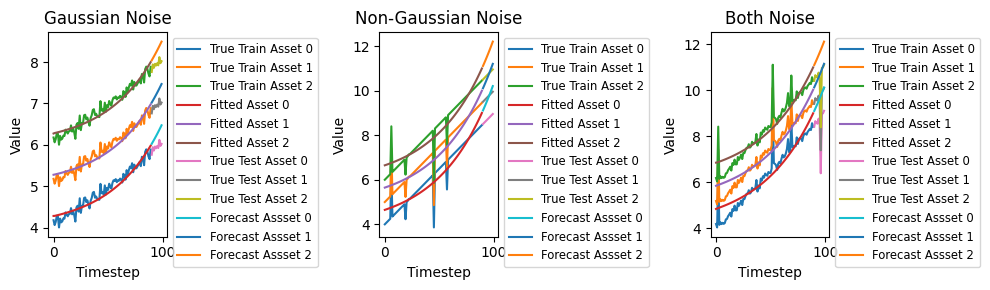

In [4]:
np.random.seed(0)
num_elements, num_features, order, test_len = 100, 3, 1, 10
toy_datasets = ToyDatasets(num_elements=num_elements, num_features=num_features)

datasets = [
  ("Gaussian Noise", np.arange(num_features).reshape((num_features, 1)) + toy_datasets.linear_trending_with_gaussian_noise().reshape(-1, 1).T), 
  ("Non-Gaussian Noise", np.arange(num_features).reshape((num_features, 1)) + toy_datasets.linear_trending_with_non_gaussian_noise().reshape(-1, 1).T),
  ("Both Noise", np.arange(num_features).reshape((num_features, 1)) + toy_datasets.linear_trending_with_both_noise().reshape(-1, 1).T),
]
fig, ax = plt.subplots(nrows=1, ncols=len(datasets), figsize=(10, 3))
for i, (title, ds) in enumerate(datasets):
  train_data, test_data = ds[:, :ds.shape[1]-test_len], ds[:, ds.shape[1]-test_len:]

  alg = Stage6Algorithm(num_features=num_features, ar_order=order)
  alg.fit(train_data)
  fitted = alg.X
  forecasted = alg.forecast(fitted, test_len)
  ax[i].plot(range(train_data.shape[1]), train_data.T, label=[f"True Train Asset {j}" for j in range(train_data.shape[0])])
  ax[i].plot(range(train_data.shape[1]), fitted.T, label=[f"Fitted Asset {j}" for j in range(fitted.shape[0])])
  ax[i].plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), test_data.T, label=[f"True Test Asset {j}" for j in range(test_data.shape[0])])
  ax[i].plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), forecasted.T, label=[f"Forecast Assset {j}" for j in range(forecasted.shape[0])])
  ax[i].set_xlabel("Timestep")
  ax[i].set_ylabel("Value")
  ax[i].set_title(title)
  ax[i].legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')

  fit_mse = alg.evaluate(train_data, alg.X)
  print(f"{title} fit MSE: ", fit_mse)
  forecast_mse = alg.evaluate(test_data, forecasted)
  print(f"{title} forecast MSE: ", forecast_mse)

plt.tight_layout()
plt.show()

Learning from scratch
`xtol` termination condition is satisfied.
Number of iterations: 985, function evaluations: 866740, CG iterations: 6538, optimality: 3.97e-01, constraint violation: 3.33e-16, execution time: 2.4e+02 s.
Gaussian Noise fit MSE:  6.837812798920195
Gaussian Noise forecast MSE:  0.8798617159330749
Learning from scratch
The maximum number of function evaluations is exceeded.
Number of iterations: 1000, function evaluations: 820000, CG iterations: 4872, optimality: 4.54e-01, constraint violation: 2.56e-14, execution time: 2.1e+02 s.
Non-Gaussian Noise fit MSE:  6.554516373379037
Non-Gaussian Noise forecast MSE:  1.053123587730873
Learning from scratch
The maximum number of function evaluations is exceeded.
Number of iterations: 1000, function evaluations: 820000, CG iterations: 7570, optimality: 4.61e-01, constraint violation: 4.49e-13, execution time: 2.6e+02 s.
Both Noise fit MSE:  6.683705012626732
Both Noise forecast MSE:  0.9194220601599669


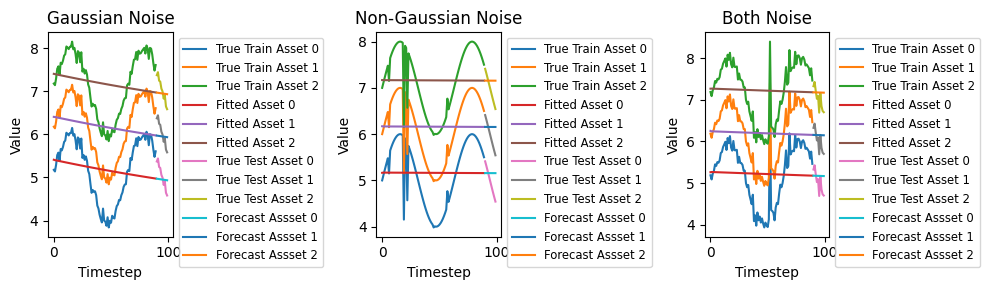

In [6]:
np.random.seed(0)
num_elements, num_features, order, test_len = 100, 3, 1, 10
toy_datasets = ToyDatasets(num_elements=num_elements, num_features=num_features)

datasets = [
  ("Gaussian Noise", np.arange(num_features).reshape((num_features, 1)) + toy_datasets.periodical_sinusoidal_with_gaussian_noise().reshape(-1, 1).T), 
  ("Non-Gaussian Noise", np.arange(num_features).reshape((num_features, 1)) + toy_datasets.periodical_sinusoidal_with_non_gaussian_noise().reshape(-1, 1).T),
  ("Both Noise", np.arange(num_features).reshape((num_features, 1)) + toy_datasets.periodical_sinusoidal_with_both_noise().reshape(-1, 1).T),
]
fig, ax = plt.subplots(nrows=1, ncols=len(datasets), figsize=(10, 3))
for i, (title, ds) in enumerate(datasets):
  train_data, test_data = ds[:, :ds.shape[1]-test_len], ds[:, ds.shape[1]-test_len:]

  alg = Stage6Algorithm(num_features=num_features, ar_order=order)
  alg.fit(train_data)
  fitted = alg.X
  forecasted = alg.forecast(fitted, test_len)
  ax[i].plot(range(train_data.shape[1]), train_data.T, label=[f"True Train Asset {j}" for j in range(train_data.shape[0])])
  ax[i].plot(range(train_data.shape[1]), fitted.T, label=[f"Fitted Asset {j}" for j in range(fitted.shape[0])])
  ax[i].plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), test_data.T, label=[f"True Test Asset {j}" for j in range(test_data.shape[0])])
  ax[i].plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), forecasted.T, label=[f"Forecast Assset {j}" for j in range(forecasted.shape[0])])
  ax[i].set_xlabel("Timestep")
  ax[i].set_ylabel("Value")
  ax[i].set_title(title)
  ax[i].legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')

  fit_mse = alg.evaluate(train_data, alg.X)
  print(f"{title} fit MSE: ", fit_mse)
  forecast_mse = alg.evaluate(test_data, forecasted)
  print(f"{title} forecast MSE: ", forecast_mse)

plt.tight_layout()
plt.show()

Learning from scratch
`xtol` termination condition is satisfied.
Number of iterations: 31, function evaluations: 14246, CG iterations: 0, optimality: 4.05e+06, constraint violation: 9.18e-39, execution time: 1.7e+01 s.
Gaussian Noise fit MSE:  14.649927935494715
Gaussian Noise forecast MSE:  3.8563093219686078
Learning from scratch
`xtol` termination condition is satisfied.
Number of iterations: 31, function evaluations: 14246, CG iterations: 0, optimality: 5.56e+06, constraint violation: 2.30e-39, execution time: 1.5e+01 s.
Non-Gaussian Noise fit MSE:  13.061360460644261
Non-Gaussian Noise forecast MSE:  3.2602234447266425
Learning from scratch
`xtol` termination condition is satisfied.
Number of iterations: 31, function evaluations: 14246, CG iterations: 0, optimality: 4.05e+06, constraint violation: 1.62e-39, execution time: 1.2e+01 s.
Both Noise fit MSE:  14.086635560008204
Both Noise forecast MSE:  3.5229936678253098


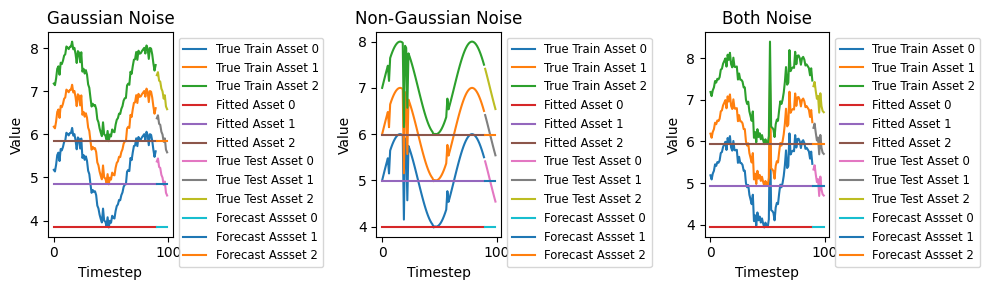

In [9]:
np.random.seed(0)
num_elements, num_features, order, test_len = 100, 3, 3, 10
toy_datasets = ToyDatasets(num_elements=num_elements, num_features=num_features)

datasets = [
  ("Gaussian Noise", np.arange(num_features).reshape((num_features, 1)) + toy_datasets.periodical_sinusoidal_with_gaussian_noise().reshape(-1, 1).T), 
  ("Non-Gaussian Noise", np.arange(num_features).reshape((num_features, 1)) + toy_datasets.periodical_sinusoidal_with_non_gaussian_noise().reshape(-1, 1).T),
  ("Both Noise", np.arange(num_features).reshape((num_features, 1)) + toy_datasets.periodical_sinusoidal_with_both_noise().reshape(-1, 1).T),
]
fig, ax = plt.subplots(nrows=1, ncols=len(datasets), figsize=(10, 3))
for i, (title, ds) in enumerate(datasets):
  train_data, test_data = ds[:, :ds.shape[1]-test_len], ds[:, ds.shape[1]-test_len:]

  alg = Stage6Algorithm(num_features=num_features, ar_order=order)
  alg.fit(train_data)
  fitted = alg.X
  forecasted = alg.forecast(fitted, test_len)
  ax[i].plot(range(train_data.shape[1]), train_data.T, label=[f"True Train Asset {j}" for j in range(train_data.shape[0])])
  ax[i].plot(range(train_data.shape[1]), fitted.T, label=[f"Fitted Asset {j}" for j in range(fitted.shape[0])])
  ax[i].plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), test_data.T, label=[f"True Test Asset {j}" for j in range(test_data.shape[0])])
  ax[i].plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), forecasted.T, label=[f"Forecast Assset {j}" for j in range(forecasted.shape[0])])
  ax[i].set_xlabel("Timestep")
  ax[i].set_ylabel("Value")
  ax[i].set_title(title)
  ax[i].legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')

  fit_mse = alg.evaluate(train_data, alg.X)
  print(f"{title} fit MSE: ", fit_mse)
  forecast_mse = alg.evaluate(test_data, forecasted)
  print(f"{title} forecast MSE: ", forecast_mse)

plt.tight_layout()
plt.show()

In [12]:
np.set_printoptions(suppress=True)
print(alg.K)

[[0.05996689 0.12364801 0.07116437 0.11425886 0.17258416 0.09829458
  0.10612354 0.17333044 0.10062493]
 [0.03354964 0.11501783 0.22503596 0.00007517 0.11059838 0.17930555
  0.08700868 0.08200731 0.1831376 ]
 [0.06161325 0.05738821 0.20390892 0.03452966 0.08523899 0.19657606
  0.06414119 0.12454034 0.18756912]]


c:\Users\chris\fyp\toy_datasets.py:81: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  returns = np.random.multivariate_normal(mean=mean_returns, cov=corr, size=self.num_elements) * volatility


Learning from scratch


c:\Users\chris\fyp\venv\lib\site-packages\scipy\optimize\_differentiable_functions.py:504: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


`xtol` termination condition is satisfied.
Number of iterations: 108, function evaluations: 41888, CG iterations: 243, optimality: 4.49e-01, constraint violation: 2.78e-16, execution time:  9.4 s.
Number of Features = 1 fit MSE:  63.89995686429618
Number of Features = 1 forecast MSE:  23.1135534534516
Learning from scratch
`xtol` termination condition is satisfied.
Number of iterations: 246, function evaluations: 255020, CG iterations: 523, optimality: 4.47e-01, constraint violation: 3.33e-16, execution time: 6.2e+01 s.
Number of Features = 3 fit MSE:  26.301616844554854
Number of Features = 3 forecast MSE:  26.907217361008353
Learning from scratch
`xtol` termination condition is satisfied.
Number of iterations: 207, function evaluations: 476096, CG iterations: 711, optimality: 4.61e-01, constraint violation: 1.25e-14, execution time: 1.3e+02 s.
Number of Features = 5 fit MSE:  46.135120692250666
Number of Features = 5 forecast MSE:  23.571957289790298


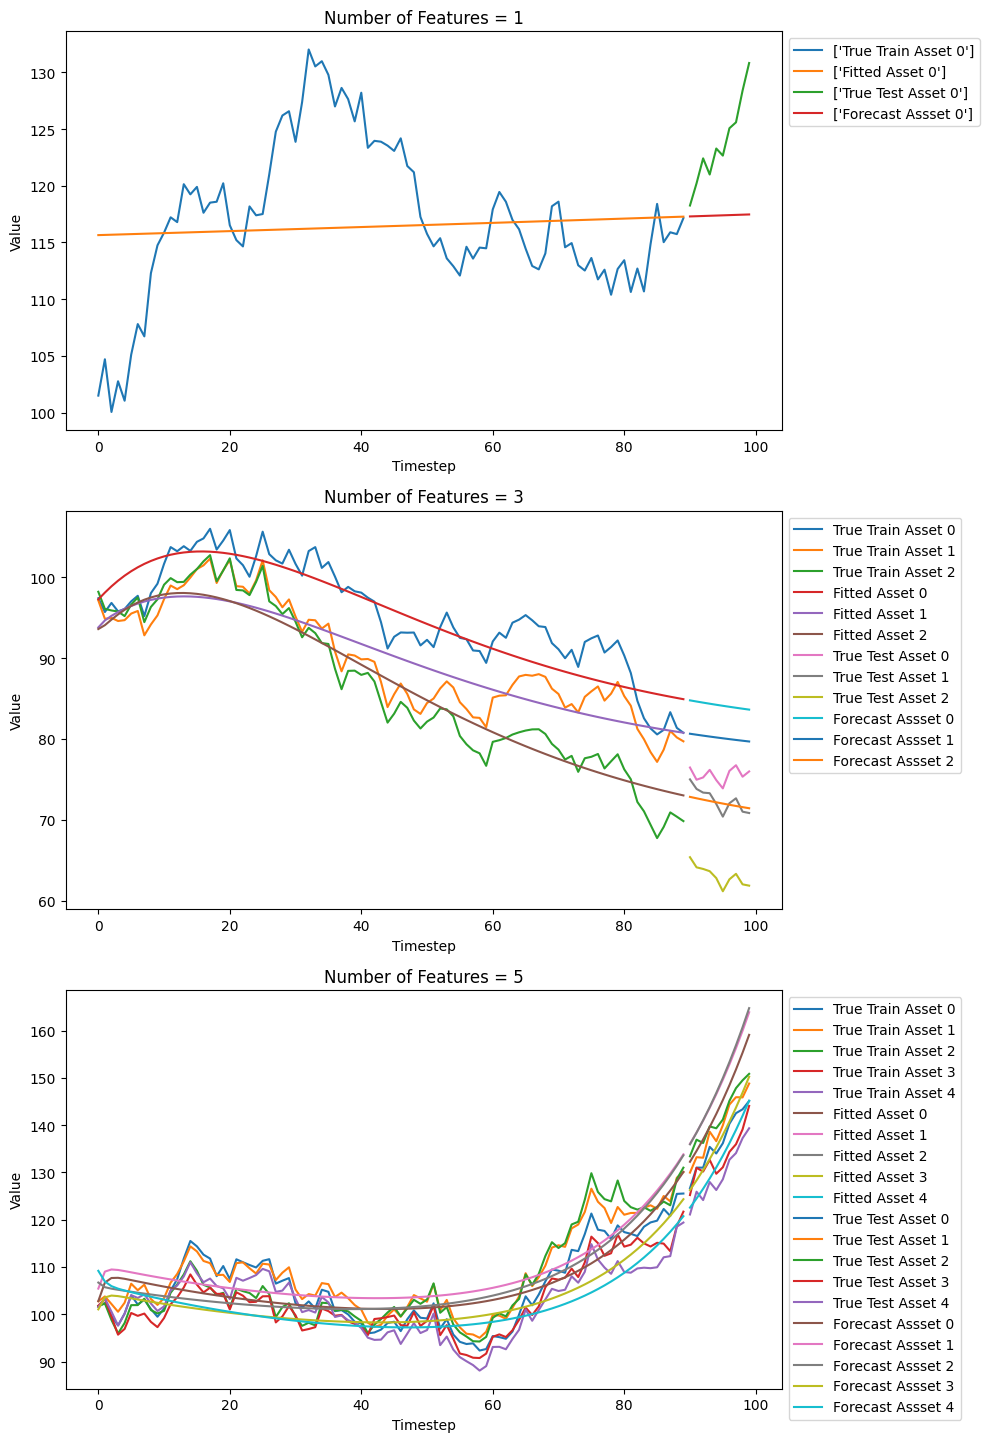

In [13]:
np.random.seed(0)
num_elements, num_features = 100, 1
toy_datasets = ToyDatasets(num_elements=num_elements, num_features=num_features)
d1 = toy_datasets.financial().T
np.random.seed(0)
num_elements, num_features = 100, 3
toy_datasets = ToyDatasets(num_elements=num_elements, num_features=num_features)
d3 = toy_datasets.financial().T
np.random.seed(0)
num_elements, num_features = 100, 5
toy_datasets = ToyDatasets(num_elements=num_elements, num_features=num_features)
d5 = toy_datasets.financial().T

order, test_len = 1, 10

datasets = [
  ("Number of Features = 1", d1), 
  ("Number of Features = 3", d3),
  ("Number of Features = 5", d5),
]
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))
for i, (title, ds) in enumerate(datasets):
  train_data, test_data = ds[:, :ds.shape[1]-test_len], ds[:, ds.shape[1]-test_len:]

  alg = Stage6Algorithm(num_features=ds.shape[0], ar_order=order)
  alg.fit(train_data)
  fitted = alg.X
  forecasted = alg.forecast(fitted, test_len)
  ax[i].plot(range(train_data.shape[1]), train_data.T, label=[f"True Train Asset {j}" for j in range(train_data.shape[0])])
  ax[i].plot(range(train_data.shape[1]), fitted.T, label=[f"Fitted Asset {j}" for j in range(fitted.shape[0])])
  ax[i].plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), test_data.T, label=[f"True Test Asset {j}" for j in range(test_data.shape[0])])
  ax[i].plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), forecasted.T, label=[f"Forecast Assset {j}" for j in range(forecasted.shape[0])])
  ax[i].set_xlabel("Timestep")
  ax[i].set_ylabel("Value")
  ax[i].set_title(title)
  ax[i].legend(loc='upper left', bbox_to_anchor=(1, 1))

  fit_mse = alg.evaluate(train_data, alg.X)
  print(f"{title} fit MSE: ", fit_mse)
  forecast_mse = alg.evaluate(test_data, forecasted)
  print(f"{title} forecast MSE: ", forecast_mse)

plt.tight_layout()
plt.show()

Learning from scratch


c:\Users\chris\fyp\venv\lib\site-packages\scipy\optimize\_trustregion_constr\equality_constrained_sqp.py:80: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  Z, LS, Y = projections(A, factorization_method)
c:\Users\chris\fyp\venv\lib\site-packages\scipy\optimize\_differentiable_functions.py:504: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)
c:\Users\chris\fyp\venv\lib\site-packages\scipy\optimize\_trustregion_constr\equality_constrained_sqp.py:203: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  Z, LS, Y = projections(A, factorization_method)


`xtol` termination condition is satisfied.
Number of iterations: 20, function evaluations: 7462, CG iterations: 0, optimality: 4.35e-01, constraint violation: 2.22e-16, execution time: 6.8e+01 s.


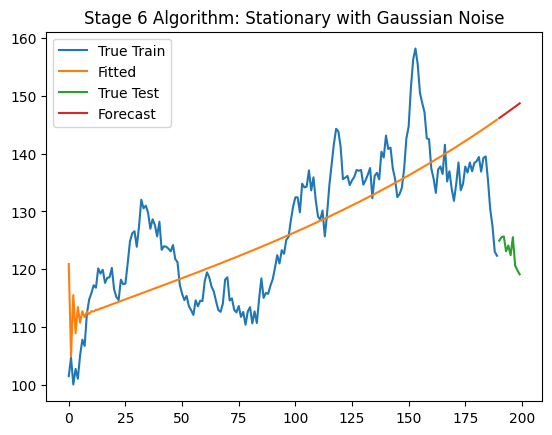

RMSE:  77.52345783460419


In [17]:
# 1m26s, 192it - BFGS
# 2m2s, 226it - SR1
np.random.seed(0)
num_elements, num_features, order, test_len = 200, 1, 3, 10
toy_datasets = ToyDatasets(num_elements=num_elements)
toy_data_full = toy_datasets.financial(num_features=num_features).T

# get first n elements
n=200
toy_data = toy_data_full[:, :n]

# run model on these 80 values
train_data, test_data = toy_data[:, :toy_data.shape[1]-test_len], toy_data[:, toy_data.shape[1]-test_len:]
alg = Stage6Algorithm(num_features=num_features, ar_order=order)

alg.fit(train_data, retrain=False)

fitted = alg.X
forecasted = alg.forecast(fitted, test_len)
plt.plot(range(train_data.shape[1]), train_data.T, label="True Train")
plt.plot(range(train_data.shape[1]), fitted.T, label="Fitted")
plt.plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), test_data.T, label="True Test")
plt.plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), forecasted.T, label="Forecast")
plt.title("Stage 6 Algorithm: Stationary with Gaussian Noise")
plt.legend()
plt.show()
accuracy = alg.evaluate(test_data, forecasted)
print("RMSE: ", accuracy)

In [ ]:
# increase dataset to 90 elements
n=85
toy_data = toy_data_full[:, :n]

# run model on these 90 values with retrain set to true
train_data, test_data = toy_data[:, :toy_data.shape[1]-test_len], toy_data[:, toy_data.shape[1]-test_len:]

alg.fit(train_data, retrain=True)

fitted = alg.X
forecasted = alg.forecast(fitted, test_len)
plt.plot(range(train_data.shape[1]), train_data.T, label="True Train")
plt.plot(range(train_data.shape[1]), fitted.T, label="Fitted")
plt.plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), test_data.T, label="True Test")
plt.plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), forecasted.T, label="Forecast")
plt.title("Stage 6 Algorithm: Stationary with Gaussian Noise")
plt.legend()
plt.show()
accuracy = alg.evaluate(test_data, forecasted)
print("RMSE: ", accuracy)

In [ ]:
np.random.seed(0)
num_elements, num_features, order, test_len = 220, 3, 1, 10
toy_datasets = ToyDatasets(num_elements=num_elements)
toy_data_full = toy_datasets.financial(num_features=num_features).T

# get first n elements
n=200
toy_data = toy_data_full[:, :n]

# run model on these 80 values
train_data, test_data = toy_data[:, :toy_data.shape[1]-test_len], toy_data[:, toy_data.shape[1]-test_len:]
alg = Stage6Algorithm(num_features=num_features, ar_order=order)

alg.fit(train_data, retrain=False)

fitted = alg.X
forecasted = alg.forecast(fitted, test_len)
plt.plot(range(train_data.shape[1]), train_data.T, label="True Train")
plt.plot(range(train_data.shape[1]), fitted.T, label="Fitted")
plt.plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), test_data.T, label="True Test")
plt.plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), forecasted.T, label="Forecast")
plt.title("Stage 6 Algorithm: Stationary with Gaussian Noise")
plt.legend()
plt.show()
accuracy = alg.evaluate(test_data, forecasted)
print("RMSE: ", accuracy)

In [ ]:
# increase dataset to 90 elements
n=205
toy_data = toy_data_full[:, :n]

# run model on these 90 values with retrain set to true
train_data, test_data = toy_data[:, :toy_data.shape[1]-test_len], toy_data[:, toy_data.shape[1]-test_len:]

alg.fit(train_data, retrain=True)

fitted = alg.X
forecasted = alg.forecast(fitted, test_len)
plt.plot(range(train_data.shape[1]), train_data.T, label="True Train")
plt.plot(range(train_data.shape[1]), fitted.T, label="Fitted")
plt.plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), test_data.T, label="True Test")
plt.plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), forecasted.T, label="Forecast")
plt.title("Stage 6 Algorithm: Stationary with Gaussian Noise")
plt.legend()
plt.show()
accuracy = alg.evaluate(test_data, forecasted)
print("RMSE: ", accuracy)

In [ ]:
data = yf.download("MSFT AAPL GOOG", period="1y")['Adj Close']
data.shape

In [ ]:
data = yf.download("MSFT AAPL GOOG", period="1y")['Adj Close']
print(data)

D = data.to_numpy().T

plt.plot(D.T)

In [ ]:
np.random.seed(0)
num_elements, num_features, order, test_len = D.shape[1], D.shape[0], 1, 10

train_data, test_data = D[:, :D.shape[1]-test_len], D[:, D.shape[1]-test_len:]

alg = Stage6Algorithm(num_features=num_features, ar_order=order)
alg.fit(train_data, retrain=False)

fitted = alg.X
forecasted = alg.forecast(fitted, test_len)
plt.plot(range(train_data.shape[1]), train_data.T, label="True Train")
plt.plot(range(train_data.shape[1]), fitted.T, label="Fitted")
plt.plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), test_data.T, label="True Test")
plt.plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), forecasted.T, label="Forecast")
plt.title("Stage 6 Algorithm: Stationary with Gaussian Noise")
plt.legend()
plt.show()
accuracy = alg.evaluate(test_data, forecasted)
print("RMSE: ", accuracy)

In [10]:
np.concatenate((D_tickers, B_tickers))

array(['AAPL', 'GOOG', 'MSFT', '^GSPC', '^IXIC'], dtype=object)

In [21]:
class SimulatedTrades():
  def __init__(self, D, B, D_tickers, B_tickers, dates):
    """
    Instantiate the model with a dataset.
    """
    self.D, self.B, self.D_tickers, self.B_tickers, self.dates = D, B, D_tickers, B_tickers, dates

  def simulate(self, n, step=21, num_periods=12, k=1, test_len=21):
    """
    Get the first n datapoints of the dataset.
    Fit an order 'k' algorithm to the first 'n-test_len' datapoints and forecast 'test_len' datapoints.
    Retrain the algorithm by extending the dataset 'step' timesteps into the future.
    At each training, calculate and store P&Ls.
    """
    
    # set up random seed for reproducability
    np.random.seed(0)

    # define data variables
    D = self.D
    B = self.B
    num_features = D.shape[0]

    # instantiate algorithm
    alg = Stage6Algorithm(num_features=num_features, ar_order=k)

    # get dates where forecasts will start
    dates = []
    for i in range(num_periods):
      idx = (n + step * i) - test_len
      start_date = self.dates[idx]
      dates.append(start_date)

    categories = ['Test', 'Benchmark']

    # set up P&L dataframe
    header = pd.MultiIndex.from_product([np.concatenate((self.D_tickers, self.B_tickers)), ['p1', 'p2', 'L/S', 'Gain', 'Percent P&L']], names=['Ticker', 'Metric'])
    df = pd.DataFrame(index=dates, columns=header)

    # loop through all the periods and forecast
    retrain = False
    for i in range(num_periods):
      D_subset, B_subset = D[:, :(n+step*i)], B[:, :(n+step*i)]
      num_elements = D_subset.shape[1]
      date = dates[i]

      # train-test split
      train_data, test_data = D_subset[:, :D_subset.shape[1]-test_len], D_subset[:, D_subset.shape[1]-test_len:]
      B_test_data = B_subset[:, B_subset.shape[1]-test_len:]

      # train the algo
      alg.fit(train_data, retrain=retrain)
      retrain = True

      # forecast
      fitted = alg.X
      forecasted = alg.forecast(fitted, test_len)
      
      # plot results
      plt.plot(range(train_data.shape[1]), train_data.T, label="True Train")
      plt.plot(range(train_data.shape[1]), fitted.T, label="Fitted")
      plt.plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), test_data.T, label="True Test")
      plt.plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), forecasted.T, label="Forecast")
      plt.title(f"Forecast {test_len} timestep from {date}")
      plt.legend()
      plt.show()

      # get the directions of price movements for D
      directions = forecasted[:, -1] - fitted[:, -1]
      for j in range(len(self.D_tickers)):
        ticker = self.D_tickers[j]
        date = self.dates[n+step*i-test_len]
        
        # for each stock, check the direction, buy or sell, calculate P&L
        direction = directions[j]
        p1, p2 = test_data[j, 0], test_data[j, -1]
        if direction >= 0:
          # long
          ls = 'L'
          gain = p2 - p1
          percent_pnl = gain / p1
        else:
          # short
          ls = 'S'
          gain = p1 - p2
          percent_pnl = gain / p2

        df.loc[date, [(ticker, 'p1'), (ticker, 'p2'), (ticker, 'L/S'), (ticker, 'Gain'), (ticker, 'Percent P&L')]] = [p1, p2, ls, gain, percent_pnl * 100]

      # benchmarks
      for j in range(len(self.B_tickers)):
        ticker = self.B_tickers[j]
        date = self.dates[n+step*i-test_len]

        # for each benchmark, get p1, p2, determine a direction, calculate P&L
        p1, p2 = B_test_data[j, 0], B_test_data[j, -1]
        gain = p2 - p1
        ls = 'L'
        percent_pnl = gain / p1
        if gain < 0:
          ls = 'S'
          gain = -1 * gain
          percent_pnl = gain / p2
        
        df.loc[date, [(ticker, 'p1'), (ticker, 'p2'), (ticker, 'L/S'), (ticker, 'Gain'), (ticker, 'Percent P&L')]] = [p1, p2, ls, gain, percent_pnl * 100]

      print(df)
      self.pnl = df
      print("------------------------------------------------------------------------------")

[*********************100%%**********************]  3 of 3 completed


Ticker            AAPL        GOOG        MSFT
Date                                          
2022-06-08  146.304764  117.237999  265.742340
2022-06-09  141.044281  114.917999  260.219391
2022-06-10  135.595932  111.427498  248.623062
2022-06-13  130.404648  106.876503  238.078278
2022-06-14  131.274796  107.194000  240.269760
...                ...         ...         ...
2024-06-03  194.029999  174.419998  413.519989
2024-06-04  194.350006  175.130005  416.070007
2024-06-05  195.869995  177.070007  424.010010
2024-06-06  194.479996  178.350006  424.519989
2024-06-07  196.889999  175.949997  423.850006

[503 rows x 3 columns]
[[146.30476379 141.04428101 135.59593201 ... 195.86999512 194.47999573
  196.88999939]
 [117.23799896 114.91799927 111.42749786 ... 177.07000732 178.3500061
  175.94999695]
 [265.74234009 260.21939087 248.62306213 ... 424.01000977 424.51998901
  423.8500061 ]]


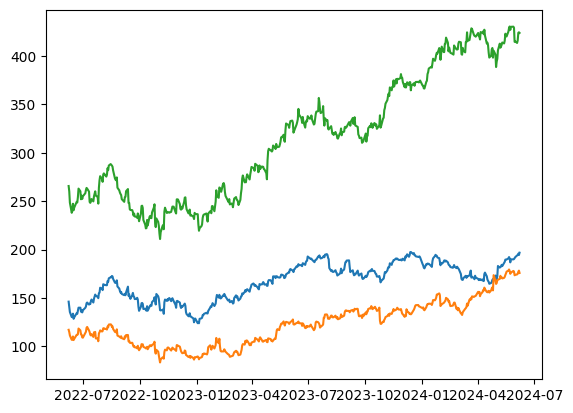

['AAPL' 'GOOG' 'MSFT']


[*********************100%%**********************]  2 of 2 completed

Ticker            ^GSPC         ^IXIC
Date                                 
2022-06-08  4115.770020  12086.269531
2022-06-09  4017.820068  11754.230469
2022-06-10  3900.860107  11340.019531
2022-06-13  3749.629883  10809.230469
2022-06-14  3735.479980  10828.349609
...                 ...           ...
2024-06-03  5283.399902  16828.669922
2024-06-04  5291.339844  16857.050781
2024-06-05  5354.029785  17187.900391
2024-06-06  5352.959961  17173.119141
2024-06-07  5346.990234  17133.130859

[503 rows x 2 columns]
[[ 4115.77001953  4017.82006836  3900.86010742 ...  5354.02978516
   5352.95996094  5346.99023438]
 [12086.26953125 11754.23046875 11340.01953125 ... 17187.90039062
  17173.11914062 17133.13085938]]


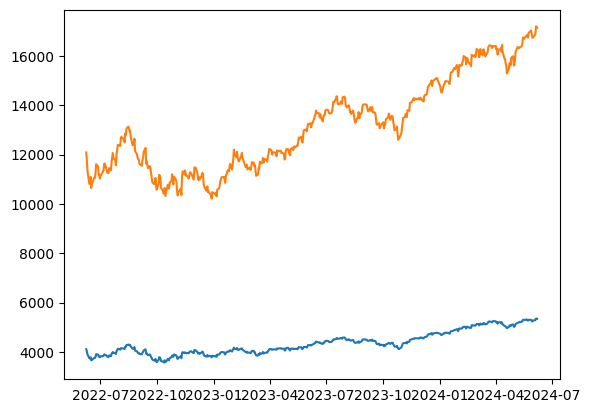

['^GSPC' '^IXIC']
['2022-06-08' '2022-06-09' '2022-06-10' '2022-06-13' '2022-06-14'
 '2022-06-15' '2022-06-16' '2022-06-17' '2022-06-21' '2022-06-22'
 '2022-06-23' '2022-06-24' '2022-06-27' '2022-06-28' '2022-06-29'
 '2022-06-30' '2022-07-01' '2022-07-05' '2022-07-06' '2022-07-07'
 '2022-07-08' '2022-07-11' '2022-07-12' '2022-07-13' '2022-07-14'
 '2022-07-15' '2022-07-18' '2022-07-19' '2022-07-20' '2022-07-21'
 '2022-07-22' '2022-07-25' '2022-07-26' '2022-07-27' '2022-07-28'
 '2022-07-29' '2022-08-01' '2022-08-02' '2022-08-03' '2022-08-04'
 '2022-08-05' '2022-08-08' '2022-08-09' '2022-08-10' '2022-08-11'
 '2022-08-12' '2022-08-15' '2022-08-16' '2022-08-17' '2022-08-18'
 '2022-08-19' '2022-08-22' '2022-08-23' '2022-08-24' '2022-08-25'
 '2022-08-26' '2022-08-29' '2022-08-30' '2022-08-31' '2022-09-01'
 '2022-09-02' '2022-09-06' '2022-09-07' '2022-09-08' '2022-09-09'
 '2022-09-12' '2022-09-13' '2022-09-14' '2022-09-15' '2022-09-16'
 '2022-09-19' '2022-09-20' '2022-09-21' '2022-09-22' '2022

In [24]:
data = yf.download("MSFT AAPL GOOG", period="2y")['Adj Close']
print(data)
D = data.to_numpy().T
print(D)
plt.plot(data)
plt.show()

D_tickers = data.columns.values
print(D_tickers)

benchmarks = yf.download("^IXIC ^GSPC", period="2y")["Adj Close"]
print(benchmarks)
B = benchmarks.to_numpy().T
print(B)
plt.plot(benchmarks)
plt.show()

B_tickers = benchmarks.columns.values
print(B_tickers)

dates = data.index.values
dates = np.datetime_as_string(dates, unit='D')
print(dates)

Learning from scratch


/vol/bitbucket/cm1220/fyp/venv/lib/python3.10/site-packages/scipy/optimize/_differentiable_functions.py:504: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


`xtol` termination condition is satisfied.
Number of iterations: 426, function evaluations: 1724144, CG iterations: 2848, optimality: 4.43e-01, constraint violation: 8.88e-16, execution time: 4.2e+02 s.


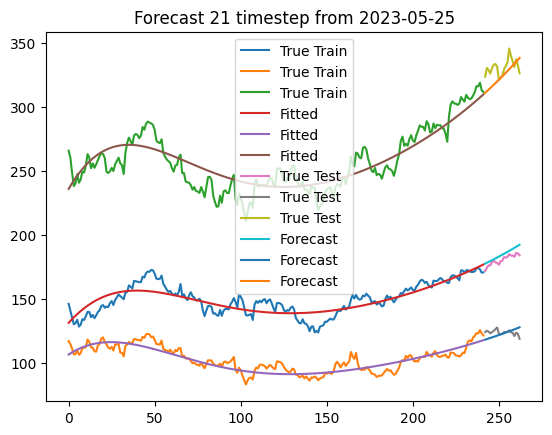

Ticker            AAPL                                                GOOG  \
Metric              p1          p2  L/S       Gain Percent P&L          p1   
2023-05-25  172.076157  184.291275    L  12.215118     7.09867  124.349998   
2023-06-27         NaN         NaN  NaN        NaN         NaN         NaN   
2023-07-27         NaN         NaN  NaN        NaN         NaN         NaN   
2023-08-25         NaN         NaN  NaN        NaN         NaN         NaN   
2023-09-26         NaN         NaN  NaN        NaN         NaN         NaN   
2023-10-25         NaN         NaN  NaN        NaN         NaN         NaN   

Ticker                                             ...        ^GSPC  \
Metric              p2  L/S      Gain Percent P&L  ...           p1   
2023-05-25  119.089996    L -5.260002   -4.229998  ...  4151.279785   
2023-06-27         NaN  NaN       NaN         NaN  ...          NaN   
2023-07-27         NaN  NaN       NaN         NaN  ...          NaN   
2023-08-25         N

/vol/bitbucket/cm1220/fyp/venv/lib/python3.10/site-packages/scipy/optimize/_differentiable_functions.py:504: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


`xtol` termination condition is satisfied.
Number of iterations: 200, function evaluations: 703592, CG iterations: 476, optimality: 4.74e-01, constraint violation: 2.00e-15, execution time: 1.5e+02 s.


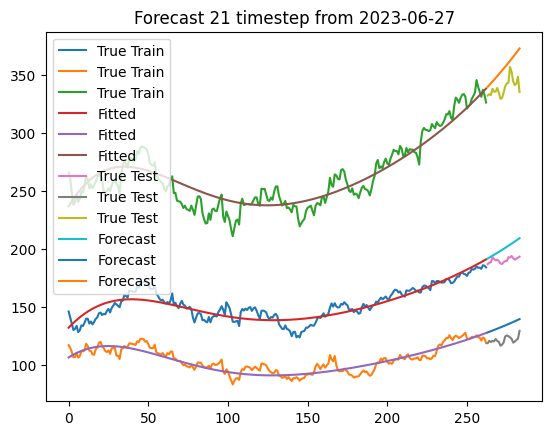

Ticker            AAPL                                                GOOG  \
Metric              p1          p2  L/S       Gain Percent P&L          p1   
2023-05-25  172.076157  184.291275    L  12.215118     7.09867  124.349998   
2023-06-27  187.066544  193.472504    L    6.40596    3.424429  119.010002   
2023-07-27         NaN         NaN  NaN        NaN         NaN         NaN   
2023-08-25         NaN         NaN  NaN        NaN         NaN         NaN   
2023-09-26         NaN         NaN  NaN        NaN         NaN         NaN   
2023-10-25         NaN         NaN  NaN        NaN         NaN         NaN   

Ticker                                              ...        ^GSPC  \
Metric              p2  L/S       Gain Percent P&L  ...           p1   
2023-05-25  119.089996    L  -5.260002   -4.229998  ...  4151.279785   
2023-06-27  129.660004    L  10.650002    8.948829  ...  4378.410156   
2023-07-27         NaN  NaN        NaN         NaN  ...          NaN   
2023-08-25     

/vol/bitbucket/cm1220/fyp/venv/lib/python3.10/site-packages/scipy/optimize/_differentiable_functions.py:504: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


`xtol` termination condition is satisfied.
Number of iterations: 186, function evaluations: 620972, CG iterations: 438, optimality: 4.93e-01, constraint violation: 1.33e-15, execution time: 1.8e+02 s.


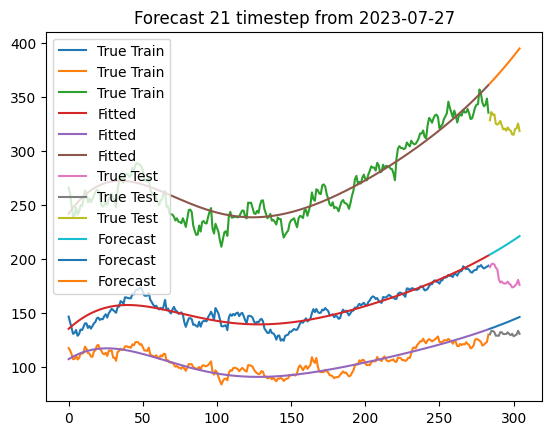

Ticker            AAPL                                                GOOG  \
Metric              p1          p2  L/S       Gain Percent P&L          p1   
2023-05-25  172.076157  184.291275    L  12.215118     7.09867  124.349998   
2023-06-27  187.066544  193.472504    L    6.40596    3.424429  119.010002   
2023-07-27  192.199265  175.685165    L -16.514099   -8.592176  129.869995   
2023-08-25         NaN         NaN  NaN        NaN         NaN         NaN   
2023-09-26         NaN         NaN  NaN        NaN         NaN         NaN   
2023-10-25         NaN         NaN  NaN        NaN         NaN         NaN   

Ticker                                              ...        ^GSPC  \
Metric              p2  L/S       Gain Percent P&L  ...           p1   
2023-05-25  119.089996    L  -5.260002   -4.229998  ...  4151.279785   
2023-06-27  129.660004    L  10.650002    8.948829  ...  4378.410156   
2023-07-27  130.419998    L   0.550003    0.423503  ...  4537.410156   
2023-08-25     

/vol/bitbucket/cm1220/fyp/venv/lib/python3.10/site-packages/scipy/optimize/_differentiable_functions.py:504: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


The maximum number of function evaluations is exceeded.
Number of iterations: 1000, function evaluations: 2763265, CG iterations: 2977, optimality: 4.94e-01, constraint violation: 4.40e-12, execution time: 1.2e+03 s.


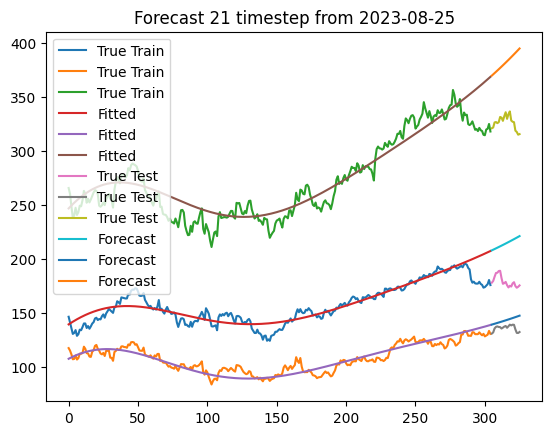

Ticker            AAPL                                                GOOG  \
Metric              p1          p2  L/S       Gain Percent P&L          p1   
2023-05-25  172.076157  184.291275    L  12.215118     7.09867  124.349998   
2023-06-27  187.066544  193.472504    L    6.40596    3.424429  119.010002   
2023-07-27  192.199265  175.685165    L -16.514099   -8.592176  129.869995   
2023-08-25  177.906387  175.386353    L  -2.520035   -1.416495  130.690002   
2023-09-26         NaN         NaN  NaN        NaN         NaN         NaN   
2023-10-25         NaN         NaN  NaN        NaN         NaN         NaN   

Ticker                                              ...        ^GSPC  \
Metric              p2  L/S       Gain Percent P&L  ...           p1   
2023-05-25  119.089996    L  -5.260002   -4.229998  ...  4151.279785   
2023-06-27  129.660004    L  10.650002    8.948829  ...  4378.410156   
2023-07-27  130.419998    L   0.550003    0.423503  ...  4537.410156   
2023-08-25  132

/vol/bitbucket/cm1220/fyp/venv/lib/python3.10/site-packages/scipy/optimize/_differentiable_functions.py:504: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


The maximum number of function evaluations is exceeded.
Number of iterations: 1000, function evaluations: 2946944, CG iterations: 1634, optimality: 4.75e-01, constraint violation: 2.90e-13, execution time: 1.3e+03 s.


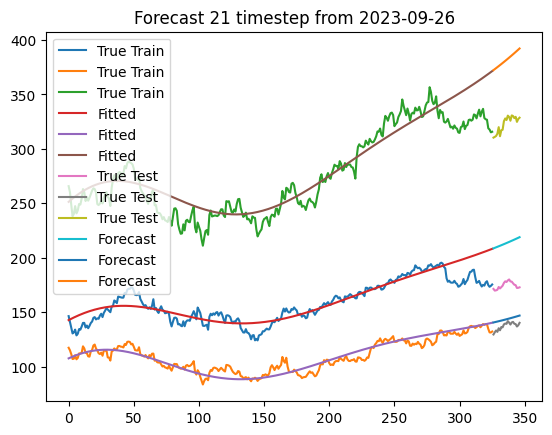

Ticker            AAPL                                                GOOG  \
Metric              p1          p2  L/S       Gain Percent P&L          p1   
2023-05-25  172.076157  184.291275    L  12.215118     7.09867  124.349998   
2023-06-27  187.066544  193.472504    L    6.40596    3.424429  119.010002   
2023-07-27  192.199265  175.685165    L -16.514099   -8.592176  129.869995   
2023-08-25  177.906387  175.386353    L  -2.520035   -1.416495  130.690002   
2023-09-26  171.282578  172.756744    L   1.474167    0.860664  129.449997   
2023-10-25         NaN         NaN  NaN        NaN         NaN         NaN   

Ticker                                              ...        ^GSPC  \
Metric              p2  L/S       Gain Percent P&L  ...           p1   
2023-05-25  119.089996    L  -5.260002   -4.229998  ...  4151.279785   
2023-06-27  129.660004    L  10.650002    8.948829  ...  4378.410156   
2023-07-27  130.419998    L   0.550003    0.423503  ...  4537.410156   
2023-08-25  132

/vol/bitbucket/cm1220/fyp/venv/lib/python3.10/site-packages/scipy/optimize/_differentiable_functions.py:504: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


The maximum number of function evaluations is exceeded.
Number of iterations: 1000, function evaluations: 3477630, CG iterations: 7164, optimality: 4.84e-01, constraint violation: 5.33e-15, execution time: 1.7e+03 s.


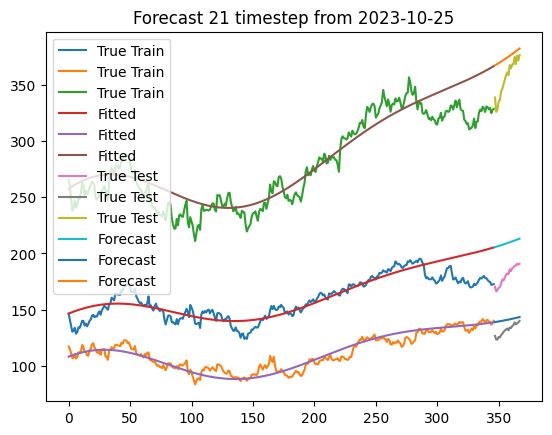

Ticker            AAPL                                               GOOG  \
Metric              p1          p2 L/S       Gain Percent P&L          p1   
2023-05-25  172.076157  184.291275   L  12.215118     7.09867  124.349998   
2023-06-27  187.066544  193.472504   L    6.40596    3.424429  119.010002   
2023-07-27  192.199265  175.685165   L -16.514099   -8.592176  129.869995   
2023-08-25  177.906387  175.386353   L  -2.520035   -1.416495  130.690002   
2023-09-26  171.282578  172.756744   L   1.474167    0.860664  129.449997   
2023-10-25  170.425964  190.807388   L  20.381424   11.959107  126.669998   

Ticker                                             ...        ^GSPC  \
Metric              p2 L/S       Gain Percent P&L  ...           p1   
2023-05-25  119.089996   L  -5.260002   -4.229998  ...  4151.279785   
2023-06-27  129.660004   L  10.650002    8.948829  ...  4378.410156   
2023-07-27  130.419998   L   0.550003    0.423503  ...  4537.410156   
2023-08-25  132.169998   L  

In [25]:
trader = SimulatedTrades(D=D, B=B, D_tickers=D_tickers, B_tickers=B_tickers, dates=dates)

step, k, num_periods, test_len = 21, 1, 6, 21
trader.simulate(n=D.shape[1]-(step-1)*num_periods*2, step=step, num_periods=num_periods, k=k, test_len=test_len)

In [19]:
pnl = trader.pnl.loc[:, pd.IndexSlice[:, 'Percent P&L']].copy()

pnl[('Ticker', 'Avg_AAPL_GOOG_MSFT')] = pnl.loc[:, pd.IndexSlice[['AAPL', 'GOOG', 'MSFT'], :]].mean(axis=1)
pnl[('Ticker', 'Avg_GSPC_IXIC')] = pnl.loc[:, pd.IndexSlice[['^GSPC', '^IXIC'], :]].mean(axis=1)

pnl

Ticker            AAPL        GOOG        MSFT       ^GSPC       ^IXIC  \
Metric     Percent P&L Percent P&L Percent P&L Percent P&L Percent P&L   
2023-05-23    8.999773    0.470437    7.755494    5.700289    8.521808   
2023-06-23    3.251561   -0.926678    3.011753    4.744581    4.197515   
2023-07-25    -8.34142    5.619351   -7.931311     4.10047    4.728977   
2023-08-23   -3.969756   -1.388789   -2.284411    2.448262      3.7587   
2023-09-22   -1.092743    4.182861    3.047233    2.270271    1.756033   
2023-10-23   10.810529    0.014506   14.844558    7.833453    9.726287   

Ticker                 Ticker                
Metric     Avg_AAPL_GOOG_MSFT Avg_GSPC_IXIC  
2023-05-23           5.741901      7.111049  
2023-06-23           1.778879      4.471048  
2023-07-25          -3.551127      4.414723  
2023-08-23          -2.547652      3.103481  
2023-09-22           2.045784      2.013152  
2023-10-23           8.556531       8.77987

In [20]:
budget_per = 1000
pnl[('Ticker', 'Ret')] = pnl.loc[:, pd.IndexSlice[['AAPL'], :]] * budget_per / 100
pnl[('Ticker', 'Ret')] = pnl.loc[:, pd.IndexSlice[['GOOG'], :]] * budget_per / 100
pnl[('Ticker', 'Ret')] = pnl.loc[:, pd.IndexSlice[['MSFT'], :]] * budget_per / 100

pnl[('Ticker', 'Sum_ret')] = pnl.loc[:, pd.IndexSlice[['AAPL', 'GOOG', 'MSFT'], :]].sum(axis=1)

pnl

Ticker            AAPL        GOOG        MSFT       ^GSPC       ^IXIC  \
Metric     Percent P&L Percent P&L Percent P&L Percent P&L Percent P&L   
2023-05-23    8.999773    0.470437    7.755494    5.700289    8.521808   
2023-06-23    3.251561   -0.926678    3.011753    4.744581    4.197515   
2023-07-25    -8.34142    5.619351   -7.931311     4.10047    4.728977   
2023-08-23   -3.969756   -1.388789   -2.284411    2.448262      3.7587   
2023-09-22   -1.092743    4.182861    3.047233    2.270271    1.756033   
2023-10-23   10.810529    0.014506   14.844558    7.833453    9.726287   

Ticker                 Ticker                                       
Metric     Avg_AAPL_GOOG_MSFT Avg_GSPC_IXIC         Ret    Sum_ret  
2023-05-23           5.741901      7.111049   77.554941  17.225704  
2023-06-23           1.778879      4.471048    30.11753   5.336636  
2023-07-25          -3.551127      4.414723  -79.313112  -10.65338  
2023-08-23          -2.547652      3.103481  -22.844108  -7.642956  
2023-09-22           2.045784      2.013152    30.47233   6.137351  
2023-10-23           8.556531       8.77987  148.445578  25.669594